In [308]:
import rasterio as rio
import geopandas as gpd
from rasterio.mask import mask
import numpy as np
from matplotlib import pyplot as plt

In [309]:
landsat = rio.open("/Users/tushimin/Desktop/550-final/merge4510/landsat8_philly.tif")
landsat

<open DatasetReader name='/Users/tushimin/Desktop/550-final/merge4510/landsat8_philly.tif' mode='r'>

In [310]:
# All of the meta data
landsat.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 952,
 'height': 1033,
 'count': 3,
 'crs': CRS.from_epsg(32618),
 'transform': Affine(30.0, 0.0, 475665.0,
        0.0, -30.0, 4443465.0)}

In [311]:
city_limits = gpd.read_file("/Users/tushimin/Desktop/week-4/data/City_Limits.geojson")
city_limits = city_limits.to_crs(landsat.crs.data['init'])

In [312]:
landsat_extent = [  
        landsat.bounds.left,
        landsat.bounds.right,
        landsat.bounds.bottom,
        landsat.bounds.top,
    ]

In [313]:
masked, mask_transform = mask(
    dataset=landsat,
    shapes=city_limits.geometry,
    crop=True,  # remove pixels not within boundary
    all_touched=True,  # get all pixels that touch the boudnary
    filled=False,  # do not fill cropped pixels with a default value
)

In [314]:
# # Initialize
# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot the first band
# ax.imshow(masked[0], cmap="viridis", extent=landsat_extent)

# # Format and add the city limits
# city_limits.boundary.plot(ax=ax, color="gray", linewidth=4)
# ax.set_axis_off()

In [315]:
# # save cropped raster data
# out_meta = landsat.meta
# out_meta.update(
#     {"height": masked.shape[1], "width": masked.shape[2], "transform": mask_transform}
# )
# print(out_meta)

# # write small image to local Geotiff file
# with rio.open("cropped_landsat.tif", "w", **out_meta) as dst:
#     dst.write(masked)

In [316]:
Band4 = masked[0]
Band5 = masked[2]
Band10 = masked[1]

In [317]:
# radience = 0.0003342*Band10+0.1-0.29

# BT = (1321.0789/np.log(774.8853/test2+1))-273.15

In [318]:
def calculate_NDVI(nir, red):
    """
    Calculate the NDVI from the NIR and red landsat bands
    """
    
    # Convert to floats
    nir = nir.astype(float)
    red = red.astype(float)
    
    # Get valid entries
    check = np.logical_and( red.mask == False, nir.mask == False )
    
    # Where the check is True, return the NDVI, else return NaN
    ndvi = np.where(check,  (nir - red ) / ( nir + red ), np.nan )
    return ndvi 

NDVI = calculate_NDVI(Band5, Band4)
# test = np.nan_to_num(NDVI, copy=True, nan=0.0, posinf=None, neginf=None)
# NDVI_min = np.amin((np.amin(test,axis=0)))
# NDVI_max = np.amax(np.amax(test,axis=0))

In [319]:
def calculate_LST(Band10,NDVI):
    
    # import module
    import numpy as np
    
    # calculate radience
    radience = 0.0003342*Band10+0.1-0.29
    
    # calculate BT
    BT = (1321.0789/np.log(774.8853/test2+1))-273.15
    
    # get the NDVI min, NDVI max
    test = np.nan_to_num(NDVI, copy=True, nan=0.0, posinf=None, neginf=None)
    NDVI_min = np.amin((np.amin(test,axis=0)))
    NDVI_max = np.amax(np.amax(test,axis=0))
    
    # calculate pv
    pv = np.square((NDVI - NDVI_min)/(NDVI_max-NDVI_min))
    
    # calculate E
    E = 0.004*pv+0.986
    
    # calculate LST
    LST = BT/(1+(10.8*BT/14388)*np.log(E))
    
    return LST

In [320]:
LST = calculate_LST(Band10,NDVI)

In [321]:
# pv = np.square((NDVI - NDVI_min)/(NDVI_max-NDVI_min))

# E = 0.004*pv+0.986

# LST = BT/(1+(10.8*BT/14388)*np.log(E))

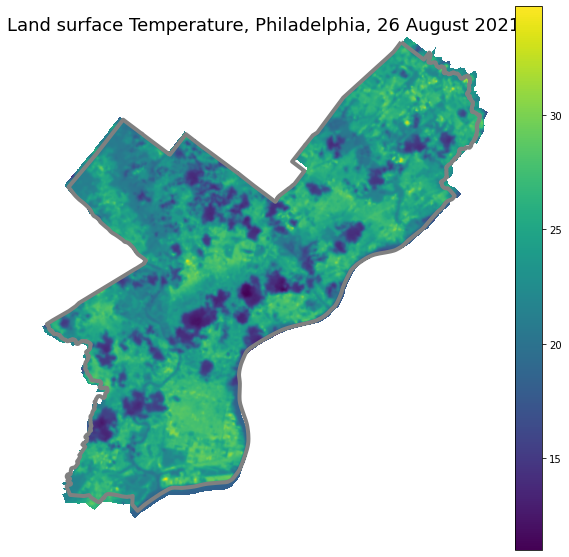

In [322]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot NDVI
img = ax.imshow(LST, extent=landsat_extent)

# Format and plot city limits
city_limits.plot(ax=ax, edgecolor='gray', facecolor='none', linewidth=4)
plt.colorbar(img)
ax.set_axis_off()
ax.set_title("Land surface Temperature, Philadelphia, 26 August 2021", fontsize=18);

In [323]:
np.amin((np.amin(LST,axis=0)))

11.010095477327763

In [324]:
np.amax((np.amax(LST,axis=0)))

34.74346432133448

Tutorial Link: https://www.youtube.com/watch?v=5AaF0-yakb8&t=501s  
Satellite Image Resource: https://www.eos.com/landviewer

In [325]:
from rasterstats import zonal_stats

In [247]:
vacant_land = gpd.read_file('/Users/tushimin/Desktop/MUSA550-final/data/Vacant_Indicators_Bldg-shp')

In [249]:
# Conver to landsat CRS
vacant_land = vacant_land.to_crs(landsat.crs.data['init'])

Create buffer:

In [269]:
stats = zonal_stats(vacant_land, LST, affine=landsat_philly.transform, stats=['median'])

In [267]:
vacant_land['median_t'] = [s['median'] for s in stats] 
vacant_land_na = vacant_land.dropna(axis=0,how='any')

In [270]:
# export temporarily
vacant_land_na.to_csv('vacant_land_na.csv',index=False)

In [271]:
landcover = gpd.read_file('/Users/tushimin/Desktop/550-final/landcover_all')
landcover = landcover.to_crs(landsat.crs.data['init'])

KeyboardInterrupt: 

In [326]:
cover_test = landcover.head(1000000)
cover_test = cover_test.reset_index(drop=True)
cover_test

,Id,gridcode,Shape_Leng,Shape_Area,geometry
0,1,2,2.000000,0.250000,"POLYGON ((2733052.500 304917.500, 2733052.500 ..."
1,2,2,16.012530,13.016906,"POLYGON ((2733053.000 304918.500, 2733055.203 ..."
2,3,2,2.000000,0.250000,"POLYGON ((2733052.000 304917.000, 2733052.000 ..."
3,4,2,2.000000,0.250000,"POLYGON ((2733051.500 304916.500, 2733051.500 ..."
4,5,2,2.000000,0.250000,"POLYGON ((2733051.000 304915.500, 2733051.000 ..."
...,...,...,...,...,...
999995,999996,7,39.170549,61.614266,"POLYGON ((2703826.500 247375.000, 2703825.996 ..."
999996,999997,2,53.754771,106.315369,"POLYGON ((2704992.000 247375.000, 2704991.203 ..."
999997,999998,1,73.165630,368.371590,"POLYGON ((2705287.500 247375.000, 2705284.723 ..."
999998,999999,2,76.571319,224.653755,"POLYGON ((2707274.000 247375.000, 2707272.258 ..."


In [ ]:
intersection = gpd.overlay(vacant_land_na,cover_test, how="intersection")

In [327]:
intersection.to_csv('intersection.csv', index=False)

NameError: name 'intersection' is not defined